In [38]:
import YXJ
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
# ----------------------------------- 数据提取 -------------------------------- 
df = pd.read_csv("数据打标/modified_data.csv")

In [39]:
# -------------------------------------- 数据增强 ---------------------------------
df1=pd.read_csv("数据打标/segment_1.csv")
df2=pd.read_csv("数据打标/segment_2.csv")
df3=pd.read_csv("数据打标/segment_3.csv")

# Create copies of the segment data
df1_copy = pd.concat([df1] * 500, ignore_index=True)
df2_copy = pd.concat([df2] * 500, ignore_index=True)
df3_copy = pd.concat([df3] * 500, ignore_index=True)

# Insert the copied segment data into the modified_data DataFrame
df = pd.concat([df, df1_copy, df2_copy, df3_copy], ignore_index=True)

In [40]:
df.columns = ["Timestamp","Accelaration-X","Accelaration-Y","Accelaration-Z",
              "AngularVelocity-X","AngularVelocity-Y","AngularVelocity-Z","latitude","longtitude","altitude",
              "speed","course","hacc","weekday","is_weekend","is_smoke"] 

# 从表格中提取collum作为numpy数组
timestamp = df["Timestamp"].to_numpy()
acceleration_x = df["Accelaration-X"].to_numpy()
acceleration_y = df["Accelaration-Y"].to_numpy()
acceleration_z = df["Accelaration-Z"].to_numpy()

isSmoke = df["is_smoke"].to_numpy()

latitude = df["latitude"].to_numpy()
longitude = df["longtitude"].to_numpy()
altitude = df["altitude"].to_numpy()

IMUdataLength =len(acceleration_x)
GPSdataLength =len(latitude)

#拉长数据，线性插值
upsampled_la= YXJ.upsampling(IMUdataLength, latitude)
upsampled_al =YXJ.upsampling(IMUdataLength, altitude)
upsampled_lo =YXJ.upsampling(IMUdataLength, longitude)

### --------------------------------------- 归一化---------------------------------------------
lo, al, la, x, y, z = [YXJ.normalization(data) for data in [upsampled_lo, upsampled_al, upsampled_la, acceleration_x, acceleration_y, acceleration_z]]

In [41]:
### ------------------------------------合并数据并转成tensor---------------------------------------------
X_data = torch.tensor([x, y, z, lo, al, la]).T
y_data = torch.tensor(isSmoke)

In [42]:
## --------------------------------------- 划分样本---------------------------------------------
width =100           # 单个样本的长度
X_data = YXJ.Split2Samples(X_data, width)                # 等分分割全部历史数据生成多个样本
X_data = torch.transpose(X_data, 0, 2).transpose(0, 1)    # 转换成：[样本数量，features，单个样本长度]
print(X_data.shape) 

torch.Size([11504, 6, 100])


In [43]:
# ------------------------------标签处理-------------------------------------
num_samples = y_data.shape[0] // width    # 计算样本数量
y_data = y_data[:num_samples * width]     # 在样本长度上截断以确保样本之间的连续性
chunked_labels = torch.chunk(y_data, chunks=num_samples, dim=0)  # 按照第0维度分割，分割成num_samples份

new_labels = torch.zeros(num_samples, 1)    # 新建一个形状为(num_samples, 1)的全零tensor
for i, chunk in enumerate(chunked_labels):
    if torch.sum(chunk) > 0:             # 如果该chunk中包含1，则该chunk标记为1
        new_labels[i] = 1

y_data = new_labels
print(num_samples)
print(y_data.shape)

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据转化为float（CNN的计算要float单精度类型）, 并移动到GPU上（加速计算）
y_data = y_data.float().to(device)
X_data = X_data.float().to(device)

11504
torch.Size([11504, 1])


In [44]:
# --------------------------------------- 划分训练集和测试集---------------------------------------------
# 将输入数据 x 和对应的标签 y 封装为一个 TensorDataset 对象
dataset = TensorDataset(X_data, y_data)

# 划分训练集和测试集
train_dataset, test_dataset = YXJ.split_dataset(dataset)

# 定义数据加载器,样本分批次
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#检查数据结构
for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)
print(len(train_loader))
print(len(test_loader))

torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size([32, 6, 100]) torch.Size([32, 1])
torch.Size

In [45]:
import torch
import torch.nn as nn

### 定义模型的结构：6条1D的CNN
out_channels =64
kernel_size = [3,2]
padding=1
stride=1
layers_num = 6
class ParallelConvModel(nn.Module):   #nn.Module是PyTorch中用于构建神经网络的基类
    ## 定义神经网络的各个层的情况
    def __init__(self):  
        super(ParallelConvModel, self).__init__()  #这是一个构造函数，被调用后可以实例化你自定义的这个神经网络   super()函数来调用基类的构造函数或方法  self相当于C#中的this
        self.conv_layers = nn.ModuleList()
        for i in range(layers_num):
            conv_layer = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size[0], padding=padding,stride=stride),     
                #in_channels=1 输入的特征数量 #out_channels=64 可以理解成要提取多少个特征    #kernel_size 卷积核的大小  #stride默认为1
                # 1D卷积层需要的是形状为(batch_size,输入通道, 序列长度)
                # 每个卷积层的输出形状为 (batch_size, out_channels, sequence_length)
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=kernel_size[1]), # 每次池化操作后，序列长度会减半
                nn.Flatten() # 除了 batch_size 会被保留外，其余的维度压平到一个维度上 （batch_size(32), out_features*sequence_length(64*20/2)）
            )
            self.conv_layers.append(conv_layer)
        outputshape = int(YXJ.calc_conv_outputshape(width, kernel_size[0], stride, padding)*out_channels*0.5*layers_num) # 计算卷积层的输出数量
        self.dense_layer = nn.Sequential(
            nn.Linear(outputshape, 30),  # 输入数量，输出数量）
            nn.Linear(30, 1),   
            nn.Sigmoid()  # 二分类问题，最终输出的是0-1之间的值
        )

    ## 定义向前传播过程
    def forward(self, x):
        conv_outputs = []  # 用于保存所有卷积层的输出
        for i in range(6):
            feature_i = x[:, i:i+1, :]                     # 沿着feature维度分割输入张量，选择第i个feature  分割后的形状(batch_size, 1, sequence_length)
            conv_output_i = self.conv_layers[i](feature_i) # 将第i个feature通过第i层卷积层
            conv_outputs.append(conv_output_i)             # 将第i层卷积层的输出添加到卷积层输出列表
        conv_output = torch.cat(conv_outputs, dim=1)       # 沿着feature维度将所有卷积层输出拼接起来
        dense_output = self.dense_layer(conv_output)       # 将拼接的卷积层输出通过全连接层
        return dense_output  

Epoch [1/100], Loss: 0.2992
Epoch [2/100], Loss: 0.1838
Epoch [3/100], Loss: 0.1636
Epoch [4/100], Loss: 0.1445
Epoch [5/100], Loss: 0.1316
Epoch [6/100], Loss: 0.1203
Epoch [7/100], Loss: 0.1246
Epoch [8/100], Loss: 0.1072
Epoch [9/100], Loss: 0.0985
Epoch [10/100], Loss: 0.0894
Epoch [11/100], Loss: 0.0851
Epoch [12/100], Loss: 0.0760
Epoch [13/100], Loss: 0.0794
Epoch [14/100], Loss: 0.0701
Epoch [15/100], Loss: 0.0709
Epoch [16/100], Loss: 0.0765
Epoch [17/100], Loss: 0.0659
Epoch [18/100], Loss: 0.0685
Epoch [19/100], Loss: 0.0613
Epoch [20/100], Loss: 0.0628
Epoch [21/100], Loss: 0.0618
Epoch [22/100], Loss: 0.0596
Epoch [23/100], Loss: 0.0573
Epoch [24/100], Loss: 0.0640
Epoch [25/100], Loss: 0.0542
Epoch [26/100], Loss: 0.0567
Epoch [27/100], Loss: 0.0568
Epoch [28/100], Loss: 0.0493
Epoch [29/100], Loss: 0.0459
Epoch [30/100], Loss: 0.0459
Epoch [31/100], Loss: 0.0483
Epoch [32/100], Loss: 0.0522
Epoch [33/100], Loss: 0.0459
Epoch [34/100], Loss: 0.0497
Epoch [35/100], Loss: 0

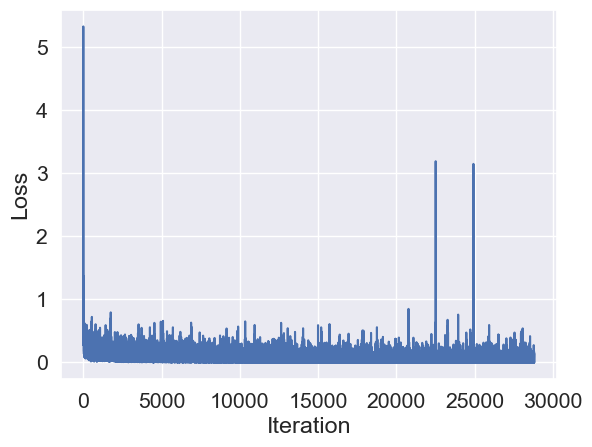

In [46]:
### ------------------------------训练模型-------------------------------------
import torch.optim as optim

losses = []   # 存储损失值的列表
# 定义模型和训练器
model = ParallelConvModel()  # 实例化模型
criterion = nn.BCELoss()   # 二分类交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

model.to(device) # 将模型移动到GPU上

# 训练
num_epochs = 100
model,losses=YXJ.train_model(model, train_loader, criterion, optimizer, num_epochs) # 调用训练函数,返回模型和loss值
YXJ.draw_loss(losses)

In [47]:
# 保存模型
torch.save(model.state_dict(), 'model.pth')

Accuracy: 98.78%
F1 score: 97.51%
Recall: 99.80%
Precision: 98.65%


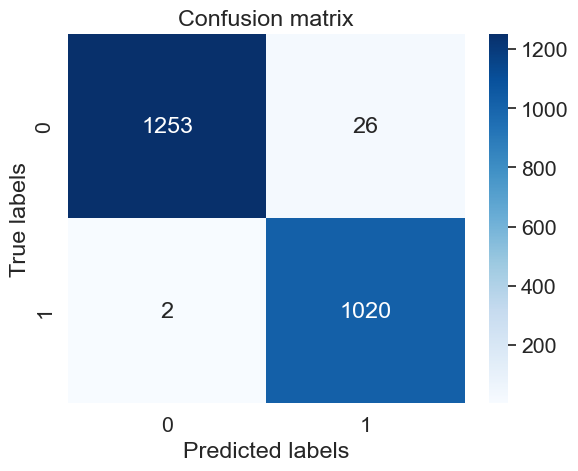

In [48]:
# 加载保存的模型参数
checkpoint = torch.load('model.pth') 
new_model=ParallelConvModel() #实例化模型
new_model.load_state_dict(checkpoint) 

### ------------------------------测试模型-------------------------------------
accuracy, f1, recall, precision,cm = YXJ.calculate_metrics(model, test_loader)
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1 score: {:.2f}%'.format(f1*100)) 
print('Recall: {:.2f}%'.format(recall*100))
print('Precision: {:.2f}%'.format(precision*100))

# 混淆矩阵
YXJ.plot_cm(cm)


In [49]:
### ------------------------------推理/预测-------------------------------------
model_path = 'model.pth'
data=torch.rand((1,6, 100)) # 生成随机数据
new_model=ParallelConvModel() #实例化模型
predict=YXJ.predict(new_model,model_path, data) # 调用预测函数
print(f"{predict.item():.4f}")

1.0000
